# FitCurve Analysis

This notebook is used to read in the outputs of the curve-fitting experiment and plot training statistics. 
First, import some libraries.

In [1]:
import os
import struct

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

ROOT_PATH = '/home/mitchell/genesetExperiments/'
CHECKPOINT_PATH = ROOT_PATH + 'full/4/'
LOG_FILE_PATH = CHECKPOINT_PATH + 'log.txt'

INPUT_PATH = ROOT_PATH + 'x.dat'
LABELS_PATH = ROOT_PATH + 'y.dat'
PREDICTIONS_FILENAME = 'predictions.dat'

Read in the log, and show the first few rows.

In [2]:
log_df = pd.read_csv(LOG_FILE_PATH)
log_df.head()

,cumulativeNumberOfEpochs,bestFitness,cumulativeElapsedTimeUs
0,100,0.522455,23182039.0
1,200,0.499963,46764360.0
2,300,0.499963,70108688.0
3,400,0.499963,93110284.0
4,500,0.000913,116029440.0


One of the first things that we can plot is the fitness as a function of the number of epochs. Notice how the optimization is not smooth; the training is stagnant for a long time, then a sudden "burst" of improvements is made. This can make it difficult to tell if the optimization has completed or gotten stuck.

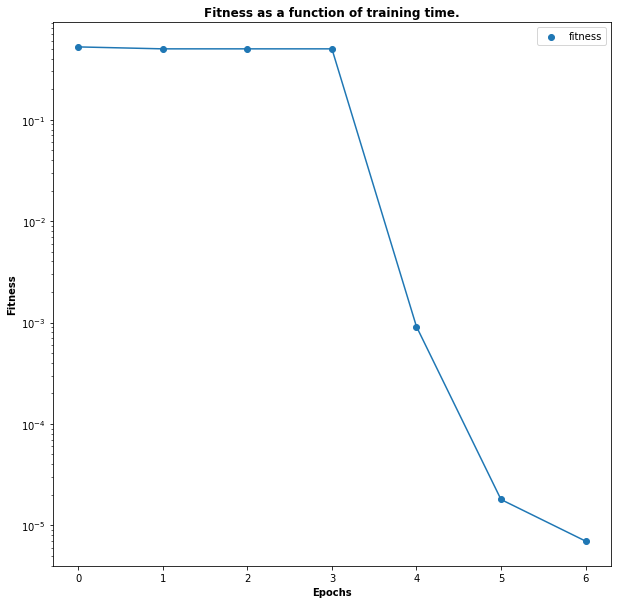

In [3]:
def plot_fitness(log_df):
    fig = plt.figure(figsize=(10,10))
    x = [i for i in range(0, log_df.shape[0], 1)]
    y = log_df['bestFitness']
    
    plt.scatter(x, y, label='fitness')
    plt.plot(x, y)
    
    plt.title('Fitness as a function of training time.', fontweight='bold')
    plt.xlabel('Epochs', fontweight='bold')
    plt.ylabel('Fitness', fontweight='bold')
    plt.yscale('log')
    plt.legend()
    
    plt.show()
    
plot_fitness(log_df)

We can plot the performance of the final algorithm against the generated labels. They appear to match exactly, indicating that the model has learned well.

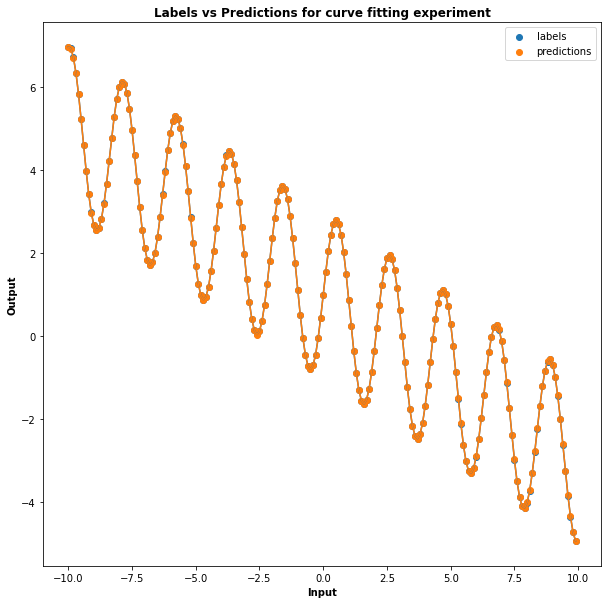

In [4]:
def read_data_file(file_name):
    file_size = os.path.getsize(file_name)
    if (file_size % 4 != 0):
        raise ValueError('File size is wrong number of bytes: {0}'.format(file_size))
        
    with open(file_name, 'rb') as f:
        data = f.read(file_size)
    
    float_size = 4
    num_floats = int(file_size / float_size)
    out_floats = []
    
    for i in range(0, num_floats, 1):
        start_idx = float_size*i
        end_idx = start_idx + float_size
        data_bytes = bytearray(data[start_idx:end_idx])
        
        out_floats.append(struct.unpack('<f', data_bytes)[0])
    
    return out_floats

def plot_predictions_and_labels(iteration_number):
    if (not isinstance(iteration_number, str)):
        iteration_number = str(iteration_number)
    x_data = read_data_file(INPUT_PATH)
    labels = read_data_file(LABELS_PATH)
    predictions = read_data_file(CHECKPOINT_PATH + iteration_number + '/' + PREDICTIONS_FILENAME)
    
    err = 0
    for i in range(0, len(x_data), 1):
        err += (predictions[i]-labels[i]) ** 2 
        
    fig = plt.figure(figsize=(10,10))

    plt.scatter(x_data, labels, label='labels')
    plt.plot(x_data, labels)

    plt.scatter(x_data, predictions, label='predictions')
    plt.plot(x_data, predictions)

    plt.title('Labels vs Predictions for curve fitting experiment', fontweight='bold')
    plt.xlabel('Input', fontweight='bold')
    plt.ylabel('Output', fontweight='bold')
    plt.legend()

    plt.show()

plot_predictions_and_labels('final')

One of the interesting questions we can ask is should we have a large number of expressive basis functions or a small number of simple basis functions. To answer that, we can plot the training progress as a function of time for an experiment using a full set of basis functions, and one using a minimal one. 

The minimal one appears to reach convergence much more quickly, which makes sense - the search space is smaller, so more combinations can be tried more efficiently.

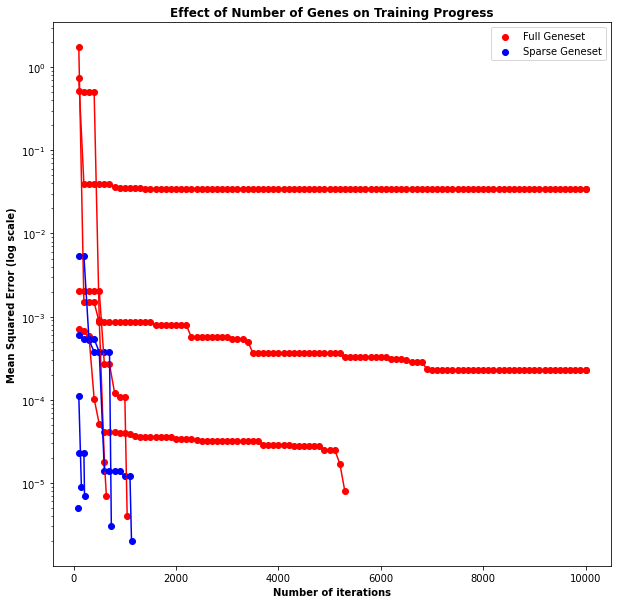

In [5]:
def read_sparse_vs_full_dfs(path):
    dirs = [d for d in os.listdir(path) if os.path.isdir(os.path.join(path, d))]

    output = {}
    for d in dirs:
        output[int(d)] = pd.read_csv(os.path.join(path, d, 'log.txt'))
    
    return output
    
def sparse_vs_full_training_progress(root_path):
    full_dir = root_path + 'full/'
    sparse_dir = root_path + 'sparse/'
    
    full_dfs = read_sparse_vs_full_dfs(full_dir)
    sparse_dfs = read_sparse_vs_full_dfs(sparse_dir)
    
    fig = plt.figure(figsize=(10,10))
    
    for attempt in full_dfs:
        xs = full_dfs[attempt]['cumulativeNumberOfEpochs']
        ys = full_dfs[attempt]['bestFitness']
        
        plt.plot(xs, ys, color='red')
        plt.scatter(xs, ys, color='red', label = ('Full Geneset' if attempt == 0 else ''))
        
    for attempt in sparse_dfs:
        xs = sparse_dfs[attempt]['cumulativeNumberOfEpochs']
        ys = sparse_dfs[attempt]['bestFitness']
        
        plt.plot(xs, ys, color='blue')
        plt.scatter(xs, ys, color='blue', label = ('Sparse Geneset' if attempt == 0 else ''))
    
    plt.yscale('log')
    plt.xlabel('Number of iterations', fontweight='bold')
    plt.ylabel('Mean Squared Error (log scale)', fontweight='bold')
    plt.title('Effect of Number of Genes on Training Progress', fontweight='bold')
    plt.legend()
    plt.show()
    
sparse_vs_full_training_progress(ROOT_PATH)